In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import seaborn as sns
import yaml

#plt.rcParams['figure.dpi'] = 300

#### Import embeddings

In [5]:
# working folder
#
tiles_dir = "/home/users/flojo/Data/Tiles"
tiles_folder = '2020_test_2400_64px'
tiles_filepath = Path(tiles_dir) / tiles_folder
tiles_meta_filepath = tiles_filepath / "meta"
tiles_images_filepath = tiles_filepath / "images"

In [6]:
embeddings_file = tiles_meta_filepath / "embs.nc"
tiles_ds = xr.open_dataset(embeddings_file)
tiles_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (tile_id: 2400, tile_type: 3, emb_dim: 100, isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int64 19kB 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * tile_type      (tile_type) <U8 96B 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 3MB ...
    isomap_coords  (isomap_dim, tile_type, tile_id) float32 58kB ...

In [ ]:
# Add lon and lat to nc file or just read from meta data?

#### Load ERA data and add to dataset if necessary

In [ ]:
# ERA5  surface level analysis parameter data on CEDA 
# - subdirectories like YYYY/MM/DD

# Variables for CAO index:
# skt: Skin temperature
# msl: Mean sea level pressure

era5_dir = "/badc/ecmwf-era5/data/oper/an_sfc/"

In [4]:
era_folder = "/home/eefjg/OneDrive/Leeds/PhD/Data/ERA5"
era_files = glob(era_folder + "/ERA5*.nc")

In [5]:
era_ds = xr.open_mfdataset(era_files, combine='by_coords')
era_ds

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'number', 'expver'}

In [6]:
# Calculate CAO index
# calculate surface theta
# calculate 800hPa theta

era_ds['theta_800'] = era_ds['t'] * (1000 / 800) ** 0.286
era_ds['theta_skt'] = era_ds['skt'] * (1000 / (era_ds['msl']/100)) ** 0.286
era_ds['cao'] = era_ds['theta_skt'] - era_ds['theta_800']
era_ds

<xarray.Dataset>
Dimensions:    (longitude: 101, latitude: 101, time: 365)
Coordinates:
  * longitude  (longitude) float32 -65.0 -64.75 -64.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2022-01-01T16:00:00 ... 2022-12-31T16:00:00
Data variables:
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    t          (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    theta_800  (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    theta_skt  (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
    cao        (time, latitude, longitude) float32 dask.array<chunksize=(365, 101, 101), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-20 14:55:23 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [11]:
# for each tile, find the nearest era5 grid point and extract era5 variables~

era_variables = ['siconc', 'cao']

for v in era_variables:
    tiles_ds[v] = xr.full_like(tiles_ds['isomap_x'], fill_value=np.nan)

In [12]:
era_ds.load()


for tile_id in tqdm(tiles_ds.tile_id):
    for tile_type in ['anchor', 'neighbor', 'distant']:
        lat = tiles_ds["c_lat"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        lon = tiles_ds["c_lon"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        time = tiles_ds["time"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        
        era_ds_tile = era_ds.sel(latitude=lat, longitude=lon, time=time, method='nearest')
        
        for v in era_variables:
            tiles_ds[v].loc[dict(tile_id=tile_id, tile_type=tile_type)] = era_ds_tile[v]

100%|██████████| 10000/10000 [01:07<00:00, 148.70it/s]


In [13]:
tiles_ds

<xarray.Dataset>
Dimensions:        (tile_id: 10000, tile_type: 3, emb_dim: 100)
Coordinates:
  * tile_id        (tile_id) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 ...
    isomap_x       (tile_type, tile_id) float32 -0.636 -0.5996 ... -0.6717
    isomap_y       (tile_type, tile_id) float32 ...
    c_lat          (tile_type, tile_id) float32 ...
    c_lon          (tile_type, tile_id) float32 ...
    time           (tile_type, tile_id) datetime64[ns] ...
    land_fraction  (tile_type, tile_id) float32 ...
    siconc         (tile_type, tile_id) float32 0.0 0.0 0.4312 ... 0.0 nan nan
    cao            (tile_type, tile_id) float32 -15.66 -6.974 ... -21.99 -12.56

In [14]:
tiles_ds.cao.mean()

<xarray.DataArray 'cao' ()>
array(-9.610518, dtype=float32)

### Plot heatmaps on manifold dimensions

In [15]:
# convert isomap coords and variables of interest to a pd dataframe for binning and plotting

variables = ['land_fraction', 'cao', 'siconc']

tiles_df = tiles_ds[['isomap_x','isomap_y']+ variables].to_dataframe()
tiles_df.head()

isomap_x  isomap_y  land_fraction        cao    siconc
tile_type tile_id                                                        
anchor    0       -0.636029  0.005927       0.000000 -15.656250  0.000000
          1       -0.599597 -0.031684       0.000000  -6.973633  0.000000
          2        0.387857  0.197076       0.000000  -6.333069  0.431157
          3        0.028068 -0.257403       0.000000 -10.542389  0.000000
          4       -0.505089 -0.013676       0.127258  -8.700714  0.000000

In [16]:
print("xmax: ", tiles_df['isomap_x'].max())
print("xmin: ", tiles_df['isomap_x'].min())
print("ymax: ", tiles_df['isomap_y'].max())
print("ymin: ", tiles_df['isomap_y'].min())

xmax:  1.9110134840011597
xmin:  -0.9486253261566162
ymax:  1.6858761310577393
ymin:  -0.9676809310913086


In [17]:
# define bins for isomap x and y, based on max and min values of isomap coordinates

# x_bins = np.linspace(-1, 2, 61)
# y_bins = np.linspace(-1, 2, 61)

# x_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.975, 1.975, 60)]
# y_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.975, 1.975, 60)]


x_bins = np.linspace(-1, 2, 31)
y_bins = np.linspace(-1, 2, 31)

x_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.95, 1.95, 30)]
y_bin_labels = ['{:.2f}'.format(i) for i in np.linspace(-0.95, 1.95, 30)]

In [18]:
# bin the data based on isomap coordinates

tiles_df['isomap_x_bin'] = pd.cut(tiles_df['isomap_x'], bins=x_bins, labels=x_bin_labels)
tiles_df['isomap_y_bin'] = pd.cut(tiles_df['isomap_y'], bins=y_bins, labels=y_bin_labels)
tiles_df.head()

isomap_x  isomap_y  land_fraction        cao    siconc  \
tile_type tile_id                                                           
anchor    0       -0.636029  0.005927       0.000000 -15.656250  0.000000   
          1       -0.599597 -0.031684       0.000000  -6.973633  0.000000   
          2        0.387857  0.197076       0.000000  -6.333069  0.431157   
          3        0.028068 -0.257403       0.000000 -10.542389  0.000000   
          4       -0.505089 -0.013676       0.127258  -8.700714  0.000000   

                  isomap_x_bin isomap_y_bin  
tile_type tile_id                            
anchor    0              -0.65         0.05  
          1              -0.55        -0.05  
          2               0.35         0.15  
          3               0.05        -0.25  
          4              -0.55        -0.05

In [19]:
# find the mean of a given variable in each bin

def bin_means(df, var):
    means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)
    means = means.iloc[::-1]    # flip the dataframe so that the y axis is increasing upwards
    return means

In [22]:
# plot heatmap of bin means

def plot_means(means_df, cmap, title, center=None, vmin=None):
    fig = sns.heatmap(means_df, cmap=cmap, center=center, vmin=vmin)
    fig.title.set_text(title)
    fig.set_xlabel('Isomap x', fontsize=10)
    fig.set_ylabel('Isomap y', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    return fig

/tmp/ipykernel_8552/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


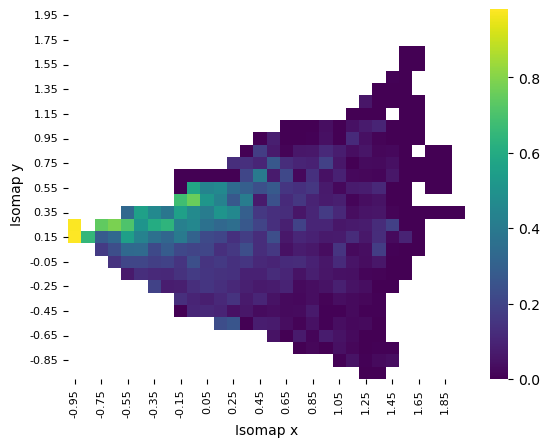

In [23]:
lf_means = bin_means(tiles_df, 'land_fraction')
plot_means(lf_means, 'viridis', 'Mean land fraction');

/tmp/ipykernel_8552/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


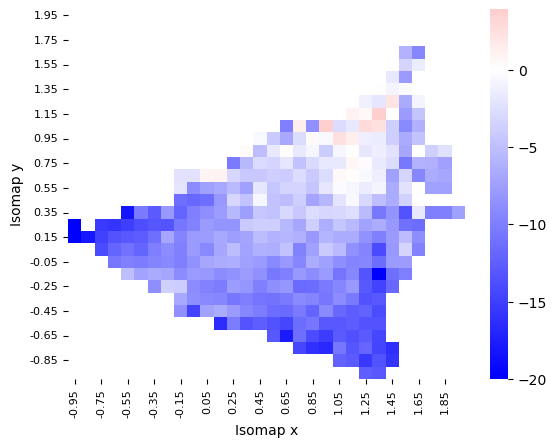

In [24]:
cao_means = bin_means(tiles_df, 'cao')
plot_means(cao_means, 'bwr', 'CAO index (K)', center=0, vmin=-20);

/tmp/ipykernel_8552/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


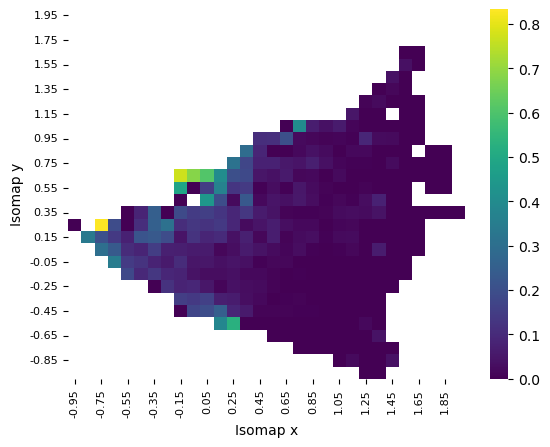

In [25]:
si_means = bin_means(tiles_df, 'siconc')
plot_means(si_means, 'viridis', 'Mean sea ice fraction');

/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


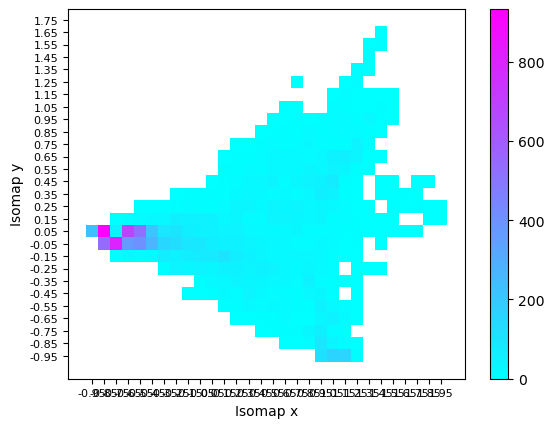

In [30]:

fig = sns.histplot(tiles_df, x='isomap_x_bin', y='isomap_y_bin', cmap='cool', cbar=True)
#fig.title.set_text(title)
fig.set_xlabel('Isomap x', fontsize=10)
fig.set_ylabel('Isomap y', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().invert_yaxis()

/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


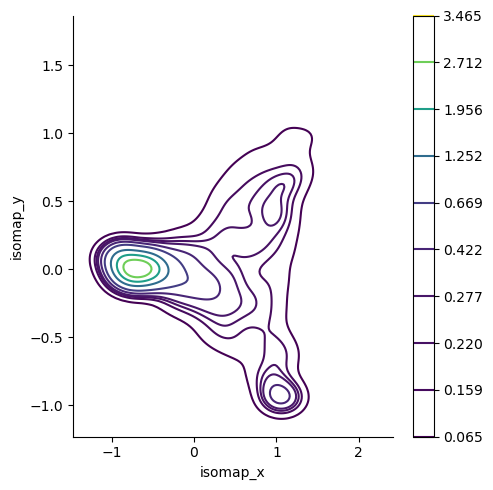

In [15]:
sns.displot(tiles_df, x='isomap_x', y='isomap_y', cmap='viridis', cbar=True, kind='kde', levels=10)